# Метод частичной дискретизации (неполный метод Галеркина / метод Галеркина-Канторовича)

\begin{cases}
L[u] \equiv u_{xx}+u_{yy}+\varkappa^2 \rho(x,y)\ u=f(x,y),\quad (x,y)\in(0,a)\times(0,b), \\
\left.L[u]\right|_\text{Г} = 0.
\end{cases}  
Будем искать $u$ в виде разложения: $u=Y^T(y)\ X(x)$, где $Y(y)$ - вектор нормированных базисных функций,
$X(x)$ - набор функций, который нам предстоит отыскать:

\begin{equation*}
Y(y)=
  \begin{pmatrix}
  \varphi_1(y) \\
  \varphi_2(y) \\
  \vdots \\
  \varphi_K(y)
  \end{pmatrix}, 
\quad \varphi_k(y)=\sqrt{\dfrac{2}{b}}\sin{\mu_k y},\ 
  \text{где}\ \mu_k=\dfrac{\pi k}{b},\ k=\overline{1,K}.
\end{equation*}

\begin{equation*}
X(x)=
  \begin{pmatrix}
  X_1(x) \\
  X_2(x) \\
  \vdots \\
  X_K(x)
  \end{pmatrix}, 
\quad k=\overline{1,K}.
\end{equation*}

Невязка: $R = Y^T X''-Y^T M^2 X+\varkappa^2\rho Y^T X-f$. Умножим $R$ слева на $Y$, проинтегрируем по $y$ и
приравняем полученный вектор к нулю: $$\int\limits_0^b Y R dy=0.$$

Введем обозначение: $\int\limits_0^b Y\rho Y^Tdy \equiv <Y\rho Y^T>.$ Тогда получаем следующую систему для $X(x)$:

\begin{cases}
X''-M^2 X+\varkappa^2 X <Y\rho Y^T> = <Yf>, \\
X(0)=X(a)=\vec 0.
\end{cases}

Введем равномерную сетку на отрезке $[0,a]$, состоящую из $N$ узлов. Тогда $X(x_1,\dots,x_N)$ будет
определяться своими сеточными
значениями:

$X_k(x_n)\equiv X_{kn},$
\begin{equation*}
X(x_1,\dots,x_N)=
\begin{pmatrix}
X_{11} & X_{12} & \ldots & X_{1N} \\
X_{21} & X_{22} & \ldots & X_{1N} \\
\vdots & \vdots & \ddots & \vdots \\
X_{K1} & X_{K2} & \ldots & X_{KN}
\end{pmatrix}.
\end{equation*}

Обозначим

\begin{equation*}
X_n\equiv X(x_n)=
\begin{pmatrix}
X_{1n} \\
X_{2n} \\
\vdots \\
X_{Kn} \\
\end{pmatrix}.
\end{equation*}

Тогда искомая функция $u$ будет иметь вид:

\begin{equation*}
u(x_1,\dots,x_N,y) =
\begin{pmatrix}
u(x_1,y)\ u(x_2,y)\ \ldots\ u(x_N,y)
\end{pmatrix} =
\begin{pmatrix}
Y^T X_1\ Y^T X_2\ \ldots\ Y^T X_N
\end{pmatrix}.
\end{equation*}

Запишем систему в разностном виде и найдем $X$ методом **матричной прогонки**.

\begin{cases}
\dfrac{X_{n-1}-2X_n+X_{n+1}}{h^2}-M^2 X_n +\varkappa^2<Y\rho(x_n,y)Y^T>X_n = <Yf(x_n,y)>,\quad n=
\overline{2:N-1}, \\
X_1 = X_N = \vec 0.
\end{cases}

In [211]:
"""
A, B, C - вектор матриц, F - массив векторов. \n
Если, например, А - матрица, считаем, что предполагается вектор одинаковых матриц. \n
Если и A, и B, и С, и F - не векторы, длина вектора решения указывается через аргумент len.
"""
function matrix_thomas(A, B, C, F; typ=Float64, len=1, F_left=nothing)
    v = filter(a->!(eltype(a) <: Number),[A,B,C,F])
    N = len == 1 ? length(v[1]) : len
    K = len == 1 ? size(v[1][1],1) : size(A,1)
    a = zeros(N+1,K,K)
    b = zeros(N+1,K)

    inside(a,b) = true in map(el->isequal(el,a),b)
    
    An = inside(A,v) ? n->A[n] : n->A
    Bn = inside(B,v) ? n->B[n] : n->B
    Cn = inside(C,v) ? n->C[n] : n->C
    Fn = inside(F,v) ? n->F[n] : n->F

#     a[2,:,:] = -Cn(1) / Bn(1)
#     b[2,:] = F_left' / Bn(1)
    for n = 1:N
        a[n+1,:,:] = -Cn(n) / (An(n)*a[n,:,:] + Bn(n))
        b[n+1,:] = (Fn(n) - An(n)*b[n,:])' / (An(n)*a[n,:,:] + Bn(n))
    end

    x = zeros(typ,K,N+1)
    for n = N:-1:1
        x[:,n] = a[n+1,:,:]*x[:,n+1] + b[n+1,:]
    end

    return x[:,1:N]
end

matrix_thomas

In [23]:
? matrix_thomas

search: matrix_thomas call_matrix_meth



A, B, C - вектор матриц, F - массив векторов. 

Если, например, А - матрица, считаем, что предполагается вектор одинаковых матриц. 

Если и A, и B, и С, и F - не векторы, длина вектора решения указывается через аргумент len.


In [515]:
a, b = 10, 10
k = sqrt((2pi/a)^2+(3pi/b)^2)

K = 200
N_ = 2^8
x = range(0,stop=a,length=N_)
h = a/(N_-1)

r1, r2, r3 = 0, 40, 0
f1(x) = b/2 - x*(a-x)/a^2*b
f2(x) = b/2 + x*(a-x)/a^2*b

mu(k) = pi*k/b
f(y,k) = sqrt(2/b)*sin(pi*k/b*y)

f (generic function with 1 method)

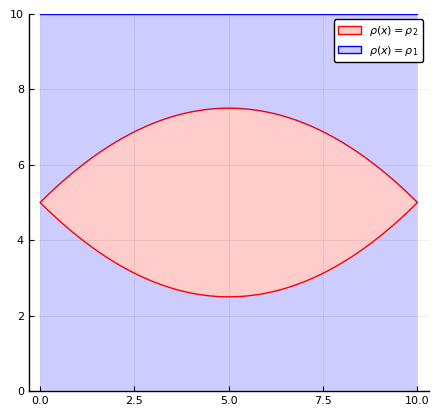

In [504]:
using LaTeXStrings
using Plots
pyplot()

span = 0:a/200:a
plot( span, f1.(span), c=:red,  fill=(0,:blue), ylim=(0,b), fillalpha=0.2, aspect_ratio=1, label="")
plot!(span, f2.(span), c=:red,  fill=(f1.(span),:red),  fillalpha=0.2, label=L"\rho(x)=\rho_2")
plot!(span, 0*span.+b, c=:blue, fill=(f2.(span),:blue), fillalpha=0.2, label=L"\rho(x)=\rho_1")
savefig("lens_rho.png")

In [103]:
using LinearAlgebra
using SymPy

y1 = Sym("y")
k1,k2 = symbols("k_1 k_2", positive=true, integer=true)
ff = simplify(integrate( 2/Sym(b)*sin(pi*k1/Sym(b)*y1)*sin(pi*k2/Sym(b)*y1), y1 ))

⎧  ⎛        ⎛π⋅k₂⋅y⎞    ⎛π⋅k₁⋅y⎞         ⎛π⋅k₁⋅y⎞    ⎛π⋅k₂⋅y⎞⎞             
⎪2⋅⎜- k₁⋅sin⎜──────⎟⋅cos⎜──────⎟ + k₂⋅sin⎜──────⎟⋅cos⎜──────⎟⎟             
⎪  ⎝        ⎝  10  ⎠    ⎝  10  ⎠         ⎝  10  ⎠    ⎝  10  ⎠⎠             
⎪─────────────────────────────────────────────────────────────  for k₁ ≠ k₂
⎪                          ⎛  2     2⎞                                     
⎪                        π⋅⎝k₁  - k₂ ⎠                                     
⎨                                                                          
⎪                                 ⎛π⋅k₂⋅y⎞                                 
⎪                   π⋅k₂⋅y - 5⋅sin⎜──────⎟                                 
⎪                                 ⎝  5   ⎠                                 
⎪                   ──────────────────────                       otherwise 
⎪                          10⋅π⋅k₂                                         
⎩                                                                          

\begin{equation*} \int\limits_0^b\varphi_{k1}(y)\rho(x_n,y)\varphi_{k2}(y)dy = 
   \rho_1\int\limits_{0}       ^{f_1(x_n)}\varphi_{k1}\varphi_{k2}dy + 
   \rho_2\int\limits_{f_1(x_n)}^{f_2(x_n)}\varphi_{k1}\varphi_{k2}dy + 
   \rho_1\int\limits_{f_2(x_n)}^{b}       \varphi_{k1}\varphi_{k2}dy.
\end{equation*}

In [104]:
free_symbols(ff[:args]()[1][:args]()[1])  # порядок аргументов нативной функций, позже поменяем на k_1,k_2,y

3-element Array{Sym,1}:
   y
 k_2
 k_1

In [105]:
free_symbols(ff[:args]()[2][:args]()[1])

2-element Array{Sym,1}:
 k_2
   y

In [516]:
ff_ij = lambdify(evalf( ff[:args]()[1][:args]()[1] ),[k1,k2,y1])
ff_ii = lambdify(evalf( ff[:args]()[2][:args]()[1] ),[k2,y1])
YrY_ij(i,j,n) = r1*(ff_ij(i,j,f1(x[n]))-ff_ij(i,j,0)) +
                r2*(ff_ij(i,j,f2(x[n]))-ff_ij(i,j,f1(x[n]))) +
                r3*(ff_ij(i,j,b)-ff_ij(i,j,f2(x[n])))
YrY_ii(i,n)   = r1*(ff_ii(i,f1(x[n]))-ff_ii(i,0)) +
                r2*(ff_ii(i,f2(x[n]))-ff_ii(i,f1(x[n]))) +
                r3*(ff_ii(i,b)-ff_ii(i,f2(x[n])))
function YrY(n)
    yry = zeros(K,K)
    for i=1:K, j=i+1:K
        yry[i,j] = YrY_ij(i,j,n)
        yry[j,i] = yry[i,j]
    end
    for i=1:K
        yry[i,i] = YrY_ii(i,n)
    end
    return yry
end

YrY_test = diagm(0=>ones(K));

In [517]:
M_square = diagm(0=>mu.(1:K).^2)

A = diagm(0=>ones(K))
B = [-2*I - h^2*M_square + h^2*k^2*YrY(n) for n=2:N_-1]
B_test = -2*I - h^2*M_square + h^2*k^2*YrY_test
C_ = diagm(0=>ones(K));

In [607]:
F_test = fill(zeros(K),N_-2)
F_1 = zeros(K)
F_1[3] = h^2*(-sqrt(b/2))*sin(2pi/a*x[2])
F_test[1] = F_1

# middle = round(Int,N_/2)+1
# F_flat = fill(zeros(K),N_-2)
freq = 135
F_delta = h^2*[zeros(freq-1); f(b/pi,freq); zeros(K-freq)]
# F_flat[middle] = F_delta
F_flat = fill(F_delta,N_-2);

In [519]:
y = range(0,stop=b,length=K)

X_test = [zeros(K) matrix_thomas(A,B_test,C_,F_test,len=N_-2) zeros(K)]
u_test_num = reshape([dot(f.(y_i,1:K), X_test[1:K,n]) for n=1:N_ for y_i in y], length(y), length(x));

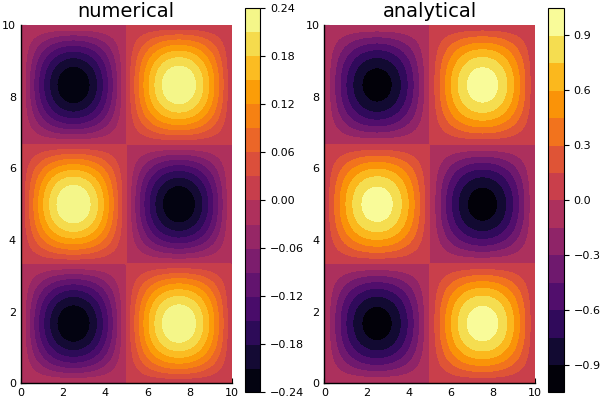

In [520]:
p1 = plot(x,y,u_test_num, fill=true,title="numerical")

u_test(x,y) = -sin(2pi/a*x)*sin(3pi/b*y)
u_test_grid = reshape([u_test(xi,yi) for xi in x for yi in y],length(y),length(x))
p2 = plot(x,y,u_test_grid,fill=true,title="analytical")

plot(p1,p2)

In [608]:
X_wave = [zeros(K) matrix_thomas(A,B_test,C_,F_flat) zeros(K)]
X = [zeros(K) matrix_thomas(A,B,C_,F_flat) zeros(K)]
u_wave = reshape([dot(f.(y_i,1:K), X_wave[1:K,n]) for n=1:N_ for y_i in y], length(y), length(x))
u = reshape([dot(f.(y_i,1:K), X[1:K,n]) for n=1:N_ for y_i in y], length(y), length(x)) - u_wave;

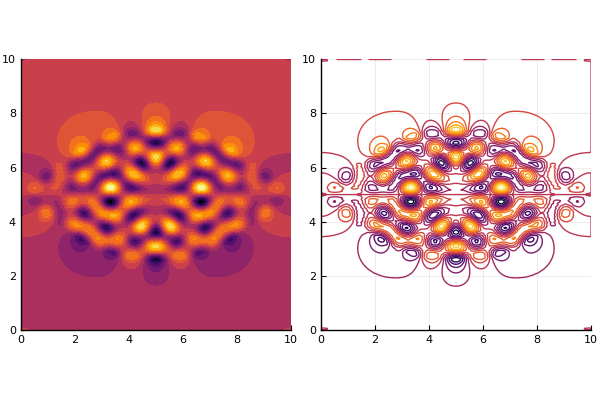

In [592]:
plot( plot(x,y,u,fill=true,legend=false), # fr=150
      plot(x,y,u,legend=false),
      aspect_ratio=1 )
# savefig("lens_04.png")

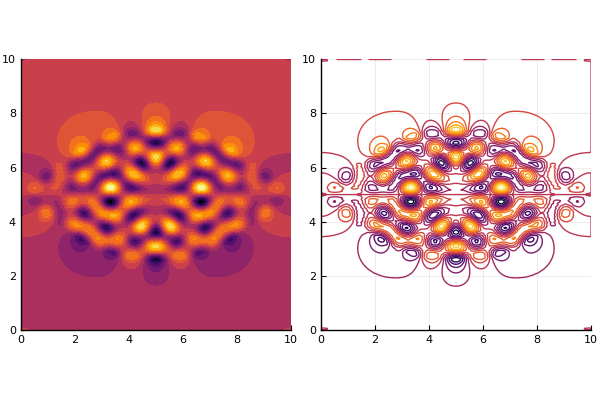

In [590]:
plot( plot(x,y,u,fill=true,legend=false), # fr=140
      plot(x,y,u,legend=false),
      aspect_ratio=1 )

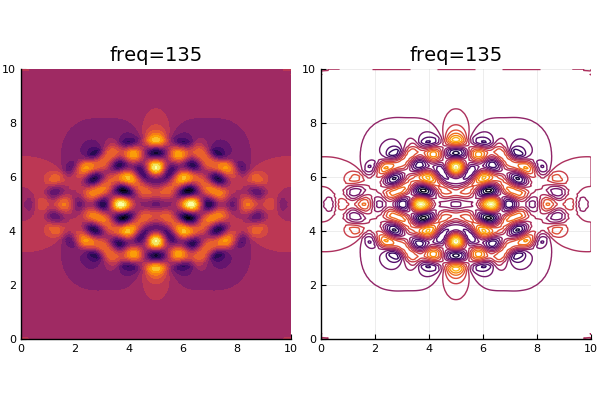

In [609]:
plot( plot(x,y,u,fill=true,legend=false), # fr=135
      plot(x,y,u,legend=false),
      aspect_ratio=1, title="freq=135" )

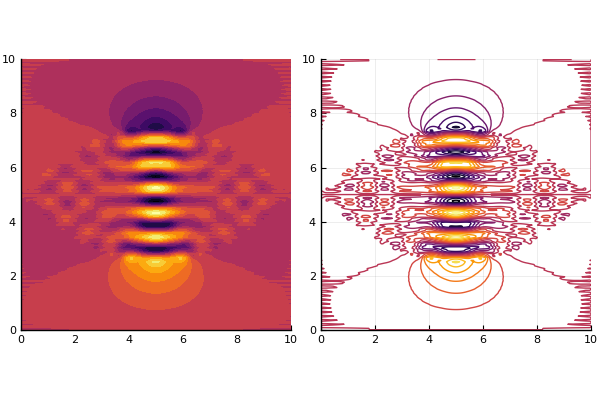

In [587]:
plot( plot(x,y,u,fill=true,legend=false), # fr=130
      plot(x,y,u,legend=false),
      aspect_ratio=1 )

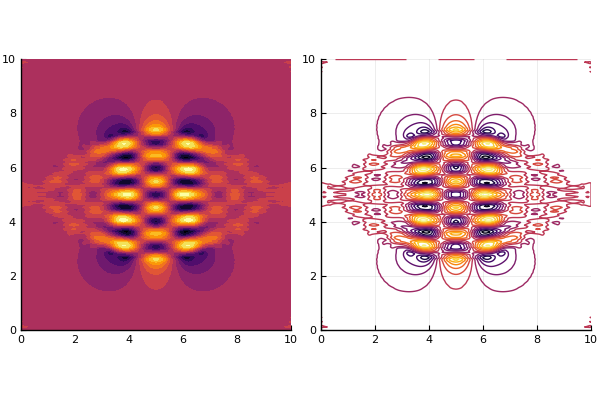

In [595]:
plot( plot(x,y,u,fill=true,legend=false), # fr=125
      plot(x,y,u,legend=false),
      aspect_ratio=1 )

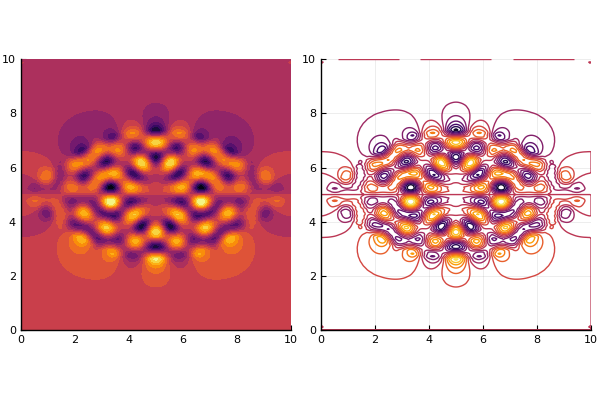

In [584]:
plot( plot(x,y,u,fill=true,legend=false), # fr=120
      plot(x,y,u,legend=false),
      aspect_ratio=1 )

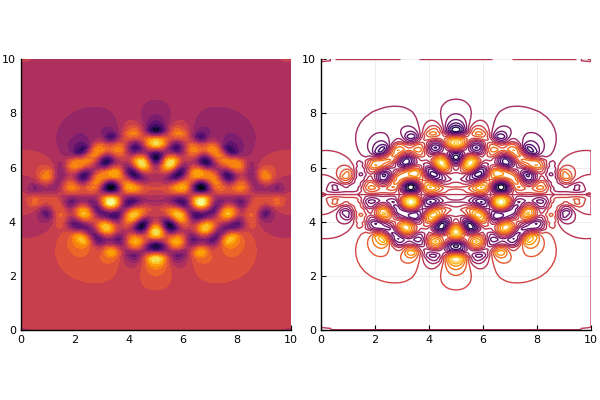

In [575]:
plot( plot(x,y,u,fill=true,legend=false), # fr=100
      plot(x,y,u,legend=false),
      aspect_ratio=1 )

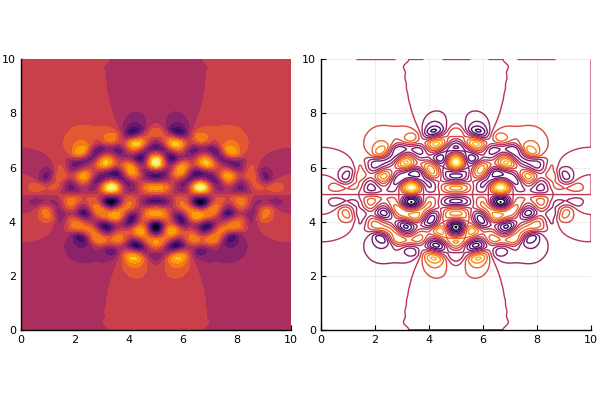

In [581]:
plot( plot(x,y,u,fill=true,legend=false), # fr=50
      plot(x,y,u,legend=false),
      aspect_ratio=1 )

In [ ]:
anim = @animate for fr = 125:135
    F_delta = h^2*[zeros(fr-1); f(b/pi,fr); zeros(K-fr)]
    F_flat = fill(F_delta,N_-2)
    
    X_wave = [zeros(K) matrix_thomas(A,B_test,C_,F_flat) zeros(K)]
    X = [zeros(K) matrix_thomas(A,B,C_,F_flat) zeros(K)]
    u_wave = reshape([dot(f.(y_i,1:K), X_wave[1:K,n]) for n=1:N_ for y_i in y], length(y), length(x))
    u = reshape([dot(f.(y_i,1:K), X[1:K,n]) for n=1:N_ for y_i in y], length(y), length(x)) - u_wave
    
    plot( plot(x,y,u,fill=true,legend=false),
      plot(x,y,u,legend=false),
      aspect_ratio=1, title="freq=$fr" )
end

In [611]:
gif(anim, "lense.gif", fps=1)

┌ Info: Saved animation to 
│   fn = /home/merlin/Labs/symbolic/lense.gif
└ @ Plots /home/merlin/.julia/packages/Plots/UtVfv/src/animation.jl:90


Plots.AnimatedGif("/home/merlin/Labs/symbolic/lense.gif")